In [3]:
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, RandomCrop, RandomHorizontalFlip
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
from torchvision.models import convnext_base, ConvNeXt_Base_Weights
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor
from torch.utils.data import DataLoader, SequentialSampler
from tqdm import tqdm

import sys
sys.path.append("..")
from src.image_data import ImageClassificationDataset
from src.quantize import cluster_feat

## Download and View Data

In [16]:
root="/mnt/ssd/ronak/datasets/fashion_mnist/"

In [17]:
train_data = FashionMNIST(root, download=True)
test_data = FashionMNIST(root, download=True, train=False)

x = train_data.data
y = np.array(train_data.targets)

print(x.shape)
print(y.shape)

torch.Size([60000, 28, 28])
(60000,)


In [18]:
x_train = np.tile(train_data.data[..., None], 3)
y_train = np.array(train_data.targets)
x_test =  np.tile(test_data.data[..., None], 3)
y_test = np.array(test_data.targets)

print(x_train.shape)
print(y_train.shape)
print(len(np.unique(y_train)))

np.save(os.path.join(root, "x_train.npy"), x_train)
np.save(os.path.join(root, "y_train.npy"), y_train)
np.save(os.path.join(root, "x_test.npy"), x_test)
np.save(os.path.join(root, "y_test.npy"), y_test)

(60000, 28, 28, 3)
(60000,)
10


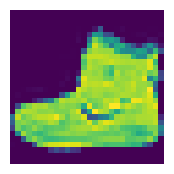

In [35]:
image = x[0]

fig, ax = plt.subplots(figsize=(2, 2))
ax.axis("off")
ax.imshow(image)
plt.show()

### Embed with ConvNeXt Model

In [15]:
DATA_PATH = '/mnt/ssd/ronak/datasets/fashion_mnist'
DEVICE = 'cuda:0'

In [18]:
model = convnext_base(weights=ConvNeXt_Base_Weights.IMAGENET1K_V1).to(DEVICE)
# train_nodes, eval_nodes = get_graph_node_names(model) # use to check layer names

In [19]:
return_nodes = {
    # node_name: user-specified key for output dict
    'avgpool': 'features',
}
body = create_feature_extractor(model, return_nodes=return_nodes)

/home/ronak/miniconda3/envs/dl/lib/python3.11/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/home/ronak/miniconda3/envs/dl/lib/python3.11/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/home/ronak/miniconda3/envs/dl/lib/python3.11/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/home/ronak/miniconda3/envs/dl/lib/python3.11/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


In [31]:
root = DATA_PATH
x_train = np.load(os.path.join(root, "x_train.npy"))
x_train = np.transpose(np.tile(x_train[..., None], 3), axes=[0, 3, 1, 2])
y_train = np.load(os.path.join(root, "y_train.npy"))
print(x_train.shape)
print(y_train.shape)

batch_size = 256
transforms = ConvNeXt_Base_Weights.IMAGENET1K_V1.transforms()
train_dataset = ImageClassificationDataset(x_train, y_train, transforms)
dataloader = DataLoader(
    train_dataset, sampler=SequentialSampler(train_dataset), batch_size=batch_size
)

(60000, 3, 28, 28)
(60000,)


In [32]:
all_image_features, all_labels, all_idx = [], [], []
with torch.no_grad():
    for i, batch in tqdm(enumerate(dataloader)):
        idx, images, labels = batch
        image_features = body(images.to(DEVICE))['features'].squeeze()
        image_features /= image_features.norm(dim=-1, keepdim=True)
        all_image_features.append(image_features)
        all_labels.append(labels)
        all_idx.append(idx)
        
all_image_features = torch.cat(all_image_features).cpu().detach().numpy()
all_labels = torch.cat(all_labels).cpu().detach().numpy()
all_idx = torch.cat(all_idx).cpu().detach().numpy()

torch.save(all_image_features, os.path.join(DATA_PATH, "convnext_base_features.pt"))
torch.save(all_labels, os.path.join(DATA_PATH, "convnext_base_labels.pt"))
torch.save(all_idx, os.path.join(DATA_PATH, "convnext_base_idx.pt"))

0it [00:00, ?it/s]/home/ronak/miniconda3/envs/dl/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
235it [08:24,  2.15s/it]


### Apply Quantization

In [12]:
NUM_CLUSTERS = 50
SEED = 11182023
DATASET = "fashion_mnist"
DATA_PATH = f'/mnt/ssd/ronak/datasets/{DATASET}'

In [13]:
all_image_features = torch.load(os.path.join(DATA_PATH, "convnext_base_features.pt"))
all_labels = torch.load(os.path.join(DATA_PATH, "convnext_base_labels.pt"))
all_idx = torch.load(os.path.join(DATA_PATH, "convnext_base_idx.pt"))

In [14]:
image_labels, image_cluster = cluster_feat(all_image_features, NUM_CLUSTERS, seed=SEED)

label_to_idx = np.argsort(all_idx)
print(all_idx[label_to_idx])

# have the labels correspond to the indices in order.
image_labels_sorted = image_labels[label_to_idx]
class_labels_sorted = all_labels[label_to_idx]

print(image_labels_sorted.shape)
print(class_labels_sorted.shape)

[    0     1     2 ... 59997 59998 59999]
(60000,)
(60000,)


In [15]:
model_name = "convnext_base"
save_dir = f'/mnt/ssd/ronak/datasets/{DATASET}/quantization/{model_name}_kmeans_{NUM_CLUSTERS}'

os.makedirs(save_dir, exist_ok=True)

np.save(os.path.join(save_dir, f'image_labels.npy'), image_labels_sorted)
np.save(os.path.join(save_dir, f'class_labels.npy'), class_labels_sorted)

_, counts = np.unique(all_labels, return_counts=True)
y_marginal = counts / np.sum(counts)
x_marginal = image_cluster.marginal

np.save(os.path.join(save_dir, f'image_marginal.npy'), x_marginal)
np.save(os.path.join(save_dir, f'class_marginal.npy'), y_marginal)